In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN


In [2]:
acc_usg = pd.read_excel('account_usage.xlsx')
acc_atr = pd.read_excel('account_attributes.xlsx')

In [3]:
print('Shape of acc_usg data frame: ',acc_usg.shape)
acc_usg.head(10)


Shape of acc_usg data frame:  (80367, 3)


,Acct id,Date time,Number of link clicks
0,SA25212,2019-10-06,2311
1,SA25212,2019-10-13,1020
2,SA25212,2019-10-20,1664
3,SA25212,2019-10-27,2523
4,SA25212,2019-11-03,1157
5,SA25212,2019-11-10,1738
6,SA25212,2019-11-17,1301
7,SA25212,2019-11-24,2485
8,SA25212,2019-12-01,2451
9,SA34768,2020-04-26,1661


In [4]:
print('Shape of acc_atr data frame: ',acc_atr.shape)
acc_atr.head(10)

Shape of acc_atr data frame:  (8000, 4)


,Acct id,Acct type,Activate chat bot,Converted to paid customer
0,SA25212,SMB,Y,0
1,SA34768,SMB,Y,0
2,SA71541,ENT,N,0
3,SA66933,SMB,Y,0
4,SA79773,ENT,Y,1
5,SA55328,SMB,Y,0
6,SA32529,SMB,N,0
7,SA50651,ENT,N,0
8,SA8330,SMB,N,0
9,SA72925,SMB,N,0


#### Account_usage contains number of clicks in a week for each accounts.
#### Account attributes contains account characteristics.

In [5]:
print('Check for null Values in acc_atr\n')
print(acc_atr.isnull().sum())
print('\nCheck for null Values in acc_usg\n')
acc_usg.isnull().sum()

Check for null Values in acc_atr

Acct id                       0
Acct type                     0
Activate chat bot             0
Converted to paid customer    0
dtype: int64

Check for null Values in acc_usg



Acct id                  0
Date time                0
Number of link clicks    0
dtype: int64

Total number of small business:  4865
Total number of enterprise business:  3135
Total number of customers:  8000


[]

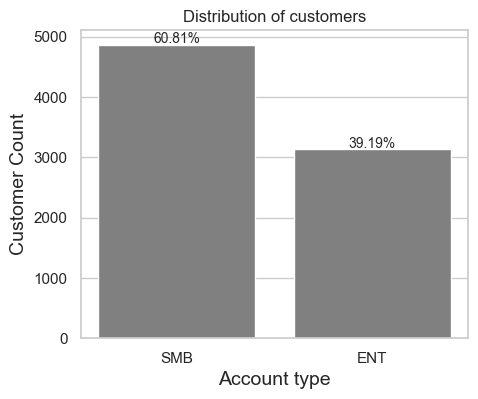

In [6]:
print('Total number of small business: ',np.count_nonzero(acc_atr['Acct type'] == 'SMB'))
print('Total number of enterprise business: ',np.count_nonzero(acc_atr['Acct type'] == 'ENT'))
print('Total number of customers: ',np.count_nonzero(acc_atr['Acct type'] == 'ENT') + np.count_nonzero(acc_atr['Acct type'] == 'SMB'))
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
ax = sns.countplot(data = acc_atr, x="Acct type",palette=['#808080'])
plt.title('Distribution of customers')
plt.xlabel('Account type', fontsize=14)
plt.ylabel('Customer Count', fontsize=14)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height -20, 
            '{:.2%}'.format(height / np.count_nonzero(acc_atr['Acct id'])),
            ha="center", va="bottom", fontsize=10)

plt.plot()

[]

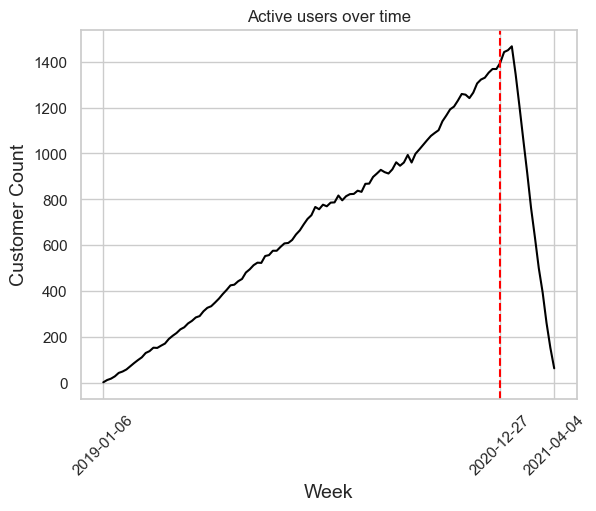

In [7]:
aggr = acc_atr.merge(acc_usg, left_on = 'Acct id', right_on = 'Acct id')
aggr.sample(10)
aggr['Date time'] = pd.to_datetime(aggr['Date time'])
aggr = aggr.sort_values(by=['Acct id', 'Date time'])

aggr['Week Number'] = aggr.groupby('Acct id').cumcount() + 1

active_users = aggr.groupby('Date time')['Acct id'].nunique().reset_index(name='id_count')

sns.lineplot(x='Date time',y = 'id_count',data = active_users, color = '#000000')
plt.title('Active users over time')
plt.xlabel('Week', fontsize=14)
plt.ylabel('Customer Count', fontsize=14)
first_day = str(active_users.loc[0,'Date time'].date())
last_day = str(active_users.loc[active_users.shape[0]-1,'Date time'].date())
specific_dates = [first_day,str(pd.to_datetime('2020-12-27')),last_day]
plt.xticks(active_users[active_users['Date time'].isin(specific_dates)]['Date time'], rotation=45)

plt.axvline(x=pd.to_datetime('2020-12-27'), color="red", linestyle="--", label="Vertical Line")
plt.plot()



The slope of regression curve is:  1.3677188032680894


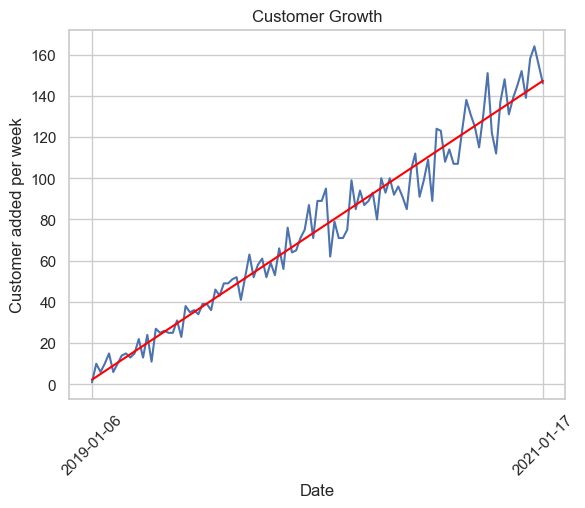

In [8]:
cust_tmp = aggr[aggr['Week Number'] == 1]
cust_grwth = cust_tmp.groupby('Date time')['Acct id'].nunique().reset_index(name='id_count')
specific_dates = [first_day,str(pd.to_datetime('2020-12-27')),last_day]
plt.xticks(active_users[active_users['Date time'].isin(specific_dates)]['Date time'], rotation=45)
cust_grwth['week'] = cust_grwth.reset_index().index + 1
sns.lineplot(x = 'week', y= 'id_count',data=cust_grwth)
slope, intercept = np.polyfit(cust_grwth["week"], cust_grwth["id_count"], 1)
x_values = np.linspace(min(cust_grwth["week"]), max(cust_grwth["week"]), 100)
y_values = slope * x_values + intercept
plt.ylabel('Customer added per week')

ax = plt.gca()

custom_xticks = [1, 107]  # Custom positions that do not match the axis type

# Set custom x-ticks
ax.set_xticks(custom_xticks)

# Set custom x-tick labels
custom_xticklabels = ['2019-01-06', '2021-01-17']
ax.set_xticklabels(custom_xticklabels)
plt.xlabel('Date')
plt.title('Customer Growth')
plt.plot(x_values, y_values, color="red", label=f'Regression Line (Slope={slope:.2f})')

print('The slope of regression curve is: ',slope)

In [9]:
acct_sum = aggr.groupby('Acct id')['Number of link clicks'].sum().reset_index(name = 'Total clicks')
aggr_clicks = pd.merge(aggr, acct_sum, on='Acct id')
aggr_clicks['Week contributions'] = aggr_clicks['Number of link clicks']/aggr_clicks['Total clicks'] *100
weeksOperations = aggr.groupby('Acct id')['Week Number'].max().reset_index(name = 'Weeks of trial')
operations = pd.merge(acc_atr,weeksOperations,on='Acct id')

aggr_clicks = pd.merge(aggr_clicks,operations)


[]

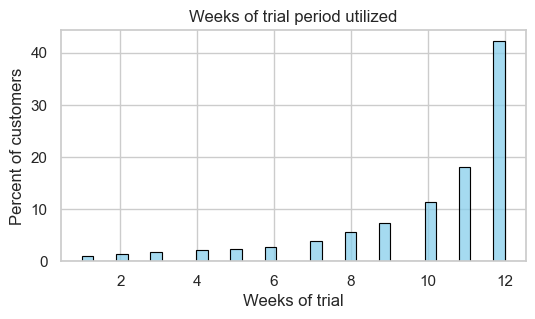

In [10]:
#sns.displot(,color='#0CBCBC', stat='percent')
sns.set(style="whitegrid")  # Set the style to whitegrid for a clean background
plt.figure(figsize=(6, 3))  # Set the figure size

sns.histplot(x='Weeks of trial',data=operations,stat='percent',color= 'skyblue', edgecolor='black')
plt.ylabel('Percent of customers')
plt.title('Weeks of trial period utilized')
plt.plot()

# t1 = x1.groupby('Weeks of trial')['Acct id'].count()
# t1

[]

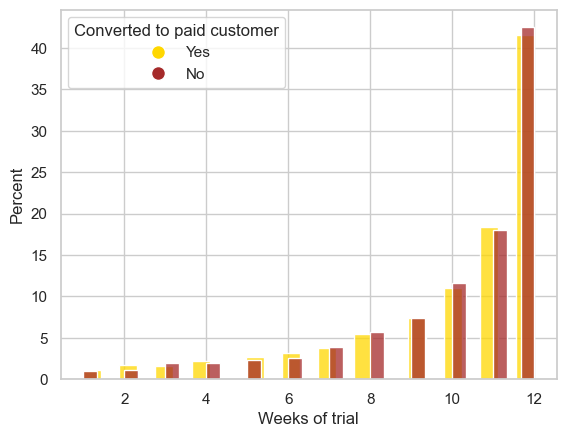

In [11]:
cond1 = operations['Converted to paid customer'] == 1
sns.histplot(data = operations[cond1],x='Weeks of trial',stat='percent',color='gold',label='Yes')
cond2 = operations['Converted to paid customer'] == 0
sns.histplot(data = operations[cond2],x='Weeks of trial',stat='percent',color='brown',label='No')
custom_legend = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='brown', markersize=10)
    
]

plt.legend(custom_legend ,['Yes', 'No'],title ='Converted to paid customer')

plt.plot()

[]

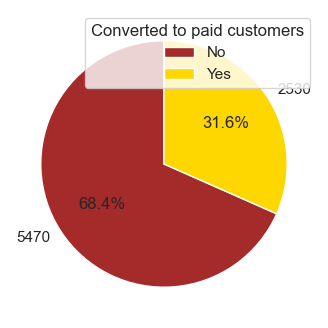

In [12]:
plt.figure(figsize=(4,4))
keys = ['Yes','No']
value = [np.count_nonzero(acc_atr['Converted to paid customer'] == 0), np.count_nonzero(acc_atr['Converted to paid customer'] == 1)]
pie, *_ = plt.pie(value,radius=1,autopct='%1.1f%%',colors = ['brown','gold'],startangle=90,labels=value)
plt.legend(pie,['No','Yes'],title='Converted to paid customers', loc='upper right')
plt.plot()

[]

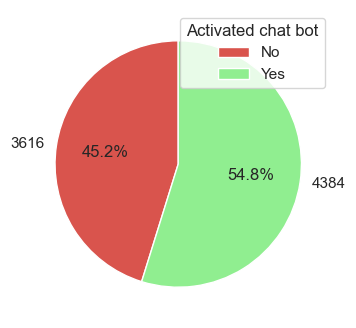

In [13]:
plt.figure(figsize=(4,4))
keys = ['Yes','No']
value = [np.count_nonzero(acc_atr['Activate chat bot'] == 'N'), np.count_nonzero(acc_atr['Activate chat bot'] == 'Y')]
pie, *_ = plt.pie(value,radius=1,autopct='%1.1f%%',colors = ['#D9544D','#90EE90'],startangle=90,labels=value)
plt.legend(pie,['No','Yes'],title='Activated chat bot', loc='upper right')
plt.plot()

[]

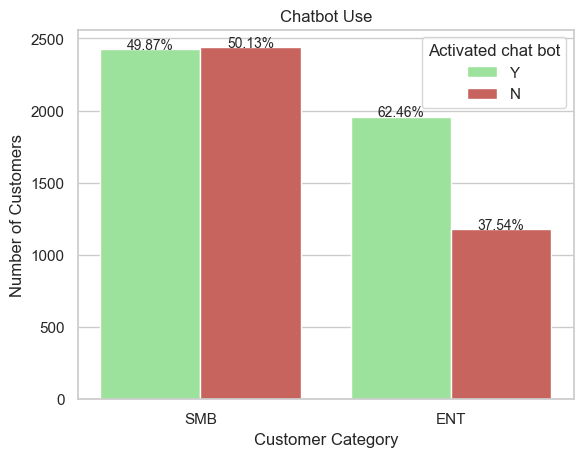

In [14]:
ax = sns.countplot(x='Acct type',hue='Activate chat bot',data=acc_atr,palette = ['#90EE90','#D9544D'])
l=[]
plt.title('Chatbot Use')
plt.xlabel('Customer Category')
plt.ylabel('Number of Customers')
plt.legend(title ='Activated chat bot')
cnt1 = acc_atr[acc_atr['Acct type']=='SMB'].shape[0]
cnt2 = acc_atr[acc_atr['Acct type']=='ENT'].shape[0]
cnt3 = acc_atr[(acc_atr['Activate chat bot']=='Y') & (acc_atr['Acct type']=='SMB')].shape[0]
cnt4 = acc_atr[(acc_atr['Activate chat bot']=='N') & (acc_atr['Acct type']=='SMB')].shape[0]
cnt5 = acc_atr[(acc_atr['Activate chat bot']=='Y') & (acc_atr['Acct type']=='ENT')].shape[0]
cnt6 = acc_atr[(acc_atr['Activate chat bot']=='N') & (acc_atr['Acct type']=='ENT')].shape[0]

ticks = [cnt3/cnt1,cnt5/cnt2,cnt4/cnt1,cnt6/cnt2]*100
for i,p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height -20, 
            '{:.2%}'.format(ticks[i]),
            ha="center", va="bottom", fontsize=10)

plt.plot()

### How to improve the program

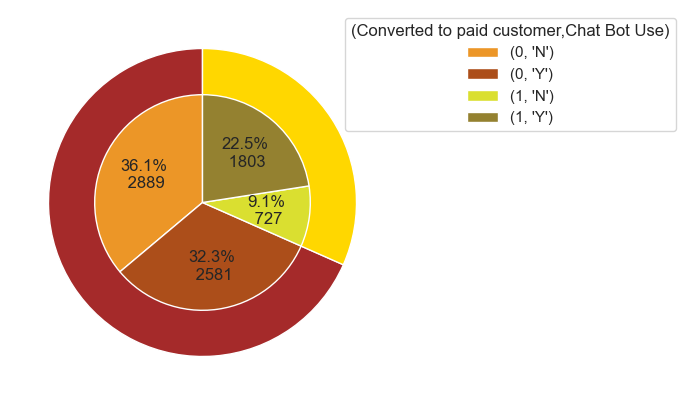

In [15]:
index = 0

def get_index():
    global index
    index = index + 1
    return index

def create_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        if get_index() % 2 == 1:
            total_1 = sum(values[::2])
        else:
            total_1 = sum(values[1::2])
        val = int(round(pct*total/100.0))
        return '{v:.1f}%\n {v1}'.format(v=pct,v1= val)
    return my_autopct


grouped_df = acc_atr.groupby(['Converted to paid customer','Activate chat bot']).size()
value = [np.count_nonzero(acc_atr['Converted to paid customer'] == 0), np.count_nonzero(acc_atr['Converted to paid customer'] == 1)]

plt.figure(figsize=(5, 5))
outer_colors = ['brown','gold']
outer_pie, *_ = plt.pie(value, startangle=90, colors=outer_colors)

inner_colors =  ["#EC9627",'#AC4E1A',"#DADF30",'#948130'] # Use a subset of colors for the inner pie chart
inner_pie, *_ = plt.pie(grouped_df, autopct=create_autopct(grouped_df), radius=0.7, startangle=90, colors=inner_colors)

plt.legend(inner_pie, grouped_df.index, title='(Converted to paid customer,Chat Bot Use)', loc='upper left', bbox_to_anchor=(0.85, 1.0))
plt.show()


Percent of converted ENT users using chatbot 83.95522388059702
Percent of converted SMB users using chatbot 49.13232104121475


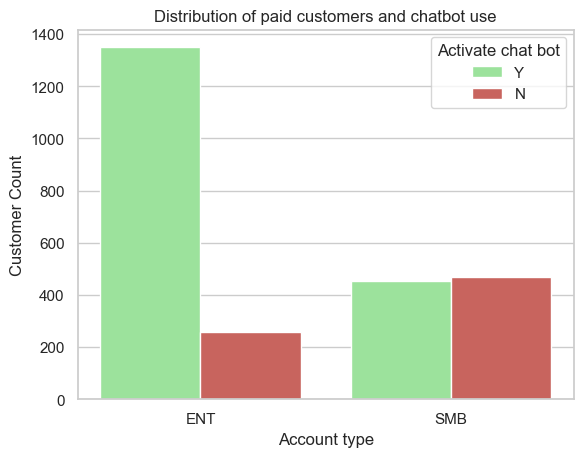

In [16]:
cond1 = acc_atr['Converted to paid customer']==1
ax = sns.countplot(x='Acct type',hue='Activate chat bot',data=acc_atr[cond1],palette = ['#90EE90','#D9544D'])
l=[]
plt.title('Distribution of paid customers and chatbot use')
plt.xlabel('Account type')
plt.ylabel('Customer Count')
plt.plot()

tmp_data = acc_atr[cond1]
cond2 = tmp_data['Acct type'] =='ENT'
cond3 = tmp_data['Acct type'] =='SMB'
cond4 = tmp_data['Activate chat bot'] =='Y'
cond5 = tmp_data['Activate chat bot'] =='N'
print("Percent of converted ENT users using chatbot",tmp_data[cond2 & cond4].shape[0]*100/tmp_data[cond2].shape[0])
print("Percent of converted SMB users using chatbot",tmp_data[cond3 & cond4].shape[0]*100/tmp_data[cond3].shape[0])

[]

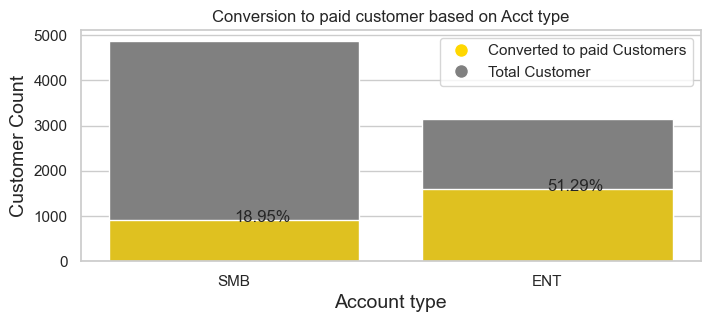

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 3))
ax1 = sns.countplot(data = acc_atr, x="Acct type",palette=['#808080'])
cust_order = ['SMB','ENT']
ax2 = sns.countplot(data = acc_atr[acc_atr['Converted to paid customer']==1], x="Acct type",palette=['#FFD700'],
                   order = cust_order)
plt.title('Conversion to paid customer based on Acct type')
plt.xlabel('Account type', fontsize=14)
plt.ylabel('Customer Count', fontsize=14)

cond1 = acc_atr['Converted to paid customer']==1
cond2 = acc_atr['Acct type']=='SMB'
cond3 = acc_atr['Acct type']=='ENT'

val1 = round(acc_atr[cond1 & cond2].shape[0]*100/acc_atr[cond2].shape[0],2)
val2 = round(acc_atr[cond1 & cond3].shape[0]*100/acc_atr[cond3].shape[0],2)

texts=['','',val1,val2]
for i,p in enumerate(ax1.patches):
    height = p.get_height()
    if(i>1):
        ax1.text(p.get_x() + p.get_width() / 2.,height -40,'{}%'.format(texts[i]))
custom_legend = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10)
    
]
plt.legend(custom_legend,['Converted to paid Customers','Total Customer'])
plt.plot()

In [18]:
aggr_clicks['Average Weekly Clicks'] = aggr_clicks['Total clicks']/aggr_clicks['Weeks of trial']
aggr_clicks.head(10)

,Acct id,Acct type,Activate chat bot,Converted to paid customer,Date time,Number of link clicks,Week Number,Total clicks,Week contributions,Weeks of trial,Average Weekly Clicks
0,SA10025,SMB,N,0,2020-01-19,1404,1,5038,27.868202,4,1259.500000
1,SA10025,SMB,N,0,2020-01-26,1091,2,5038,21.655419,4,1259.500000
2,SA10025,SMB,N,0,2020-02-02,1183,3,5038,23.481540,4,1259.500000
3,SA10025,SMB,N,0,2020-02-09,1360,4,5038,26.994839,4,1259.500000
4,SA10036,SMB,Y,0,2020-11-22,4478,1,37205,12.036017,12,3100.416667
5,SA10036,SMB,Y,0,2020-11-29,918,2,37205,2.467410,12,3100.416667
6,SA10036,SMB,Y,0,2020-12-06,2429,3,37205,6.528692,12,3100.416667
7,SA10036,SMB,Y,0,2020-12-13,5423,4,37205,14.575998,12,3100.416667
8,SA10036,SMB,Y,0,2020-12-20,3631,5,37205,9.759441,12,3100.416667
9,SA10036,SMB,Y,0,2020-12-27,1573,6,37205,4.227926,12,3100.416667


Average weekly clicks of converted customers:  1025.2688582464964
Average weekly clicks of not converted customers:  768.4682089041366


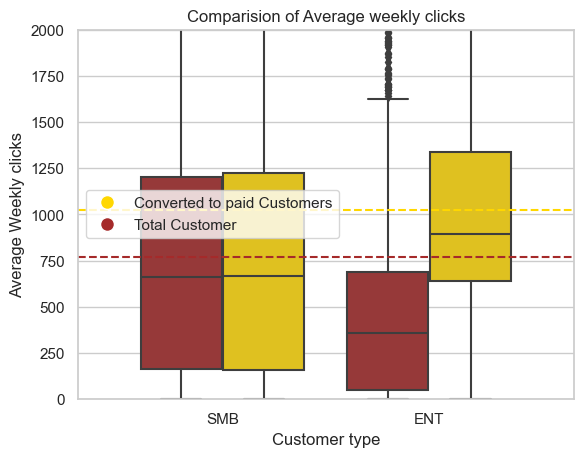

In [19]:
avg_clicks = aggr_clicks.groupby('Acct id')['Number of link clicks'].mean().reset_index(name='Average Weekly clicks')
clicks = pd.merge(avg_clicks,acc_atr,on='Acct id')
cond1 = clicks['Converted to paid customer'] == 1
cond2 = clicks['Converted to paid customer'] == 0
cond3 = clicks['Acct type'] == 'SMB'
cond4 = clicks['Acct type'] == 'ENT'

avg_values=[]
avg_values.append(clicks[cond1&cond3]['Average Weekly clicks'].mean())
avg_values.append(clicks[cond1&cond4]['Average Weekly clicks'].mean())
avg_values.append(clicks[cond2&cond3]['Average Weekly clicks'].mean())
avg_values.append(clicks[cond2&cond4]['Average Weekly clicks'].mean())

custom_palette ={1:'gold',0:'brown'}

ax = sns.boxplot(x= 'Acct type',y='Average Weekly clicks',hue ='Converted to paid customer',palette=custom_palette,data=clicks)
plt.axhline(y=clicks[cond1]['Average Weekly clicks'].mean(), color='gold', linestyle="--", label="Converted Customers")
plt.axhline(y=clicks[cond2]['Average Weekly clicks'].mean(), color='brown', linestyle="--", label="Not Converted Customer")

plt.ylim(0,2000)
plt.title('Comparision of Average weekly clicks')

custom_legend = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='brown', markersize=10)
    
]
plt.legend(custom_legend,['Converted to paid Customers','Total Customer'])
plt.xlabel('Customer type')
plt.plot()
print('Average weekly clicks of converted customers: ',clicks[cond1]['Average Weekly clicks'].mean())
print('Average weekly clicks of not converted customers: ',clicks[cond2]['Average Weekly clicks'].mean())


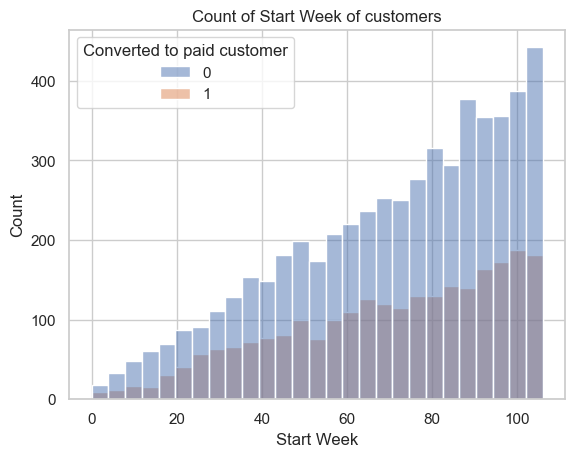

In [20]:
aggr_week_nm = aggr_clicks[aggr_clicks['Week Number']==1].loc[:,['Acct id','Date time','Converted to paid customer']].reset_index()
unq_dates = pd.Series(aggr_clicks['Date time'].unique())
#sns.countplot(x='Date time',hue='Converted to paid customer')
date_map = dict()
for i,dates in enumerate(unq_dates.sort_values()):
    date_map[dates] = i
#date_map
aggr_week_nm['Start Week'] = aggr_week_nm['Date time'].map(date_map)
sns.histplot(x='Start Week',hue = 'Converted to paid customer',data = aggr_week_nm)
plt.title('Count of Start Week of customers')
plt.plot()
aggr_week_nm = aggr_week_nm.drop(['index','Date time','Converted to paid customer'],axis = 1)
#aggr_week_nm

#### Building models

In [21]:
dataset = acc_atr.copy()
tmp = aggr_clicks.groupby('Acct id')['Number of link clicks'].mean().reset_index(name = 'Avg Weekly clicks')
dataset = pd.merge(dataset,tmp,on='Acct id')
tmp = aggr_clicks.groupby('Acct id')['Total clicks'].mean().reset_index(name = 'Total clicks')
dataset = pd.merge(dataset,tmp,on='Acct id')
ohe = OneHotEncoder(sparse = False)
dataset.loc[:,['SMB','ENT']] = pd.DataFrame(ohe.fit_transform(dataset[['Acct type']]), columns=['ENT', 'SMB'])

cb_data = pd.DataFrame(ohe.fit_transform(dataset[['Activate chat bot']]), columns=['CB_N', 'CB_Y'])

dataset.loc[:,['CB_N','CB_Y']] = cb_data
dataset = dataset.drop('Activate chat bot',axis=1)
dataset = dataset.drop('Acct type',axis=1)
dataset = dataset.drop('Acct id',axis=1)


In [22]:
def under_sampling(dataset,factor=1.5):
    cond1 = dataset['Converted to paid customer'] == 1
    cond2 = dataset['Converted to paid customer'] == 0
    y1_cnt = dataset[cond1].shape[0]
    y0_cnt = dataset[cond2].shape[0]
    if(y1_cnt>y0_cnt and 1-(y0_cnt/y1_cnt)*factor>0):
        drop_indices = dataset[cond1].sample(frac=(1-(y0_cnt/y1_cnt)*factor)).index
    elif(1-(y1_cnt/y0_cnt)*factor>0 and y0_cnt>y1_cnt):
        drop_indices = dataset[cond2].sample(frac=(1-(y1_cnt/y0_cnt)*factor)).index
    print(dataset[cond1].shape[0],dataset[cond2].shape[0])
    dataset = dataset.drop(drop_indices)
    print(dataset[cond1].shape[0],dataset[cond2].shape[0])
    return dataset




output_col = 'Converted to paid customer'
input_col = ['Avg Weekly clicks','ENT','CB_Y']



X = dataset.loc[:,input_col]
y = dataset.loc[:,output_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state = 120)



smote = SMOTEENN(sampling_strategy='auto',random_state=150)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



print("Number of train samples:", X_resampled.shape[0])
print("Number of test samples:", y_test.shape[0])




Number of train samples: 3755
Number of test samples: 800


              precision    recall  f1-score   support

           0       0.82      0.78      0.80       565
           1       0.53      0.59      0.56       235

    accuracy                           0.73       800
   macro avg       0.68      0.69      0.68       800
weighted avg       0.74      0.73      0.73       800


Accuracy: 0.7275

Cross validation Result: 
[0.92143808 0.91211718 0.9494008  0.96005326 0.95739015]


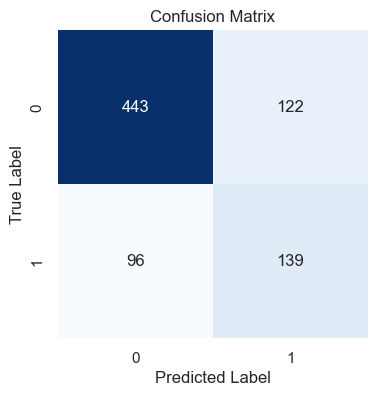

In [23]:
xgb_classifier = XGBClassifier(max_depth=5,n_estimators = 100, objective='binary:logistic'
                              ,random_state = 300,use_label_encoder=False, eval_metric='logloss')

cv_results = cross_val_score(xgb_classifier, X_resampled, y_resampled, scoring="accuracy",
                         cv=5)

xgb_classifier.fit(X_resampled, y_resampled)

y_pred = xgb_classifier.predict(X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)



print("\nCross validation Result: ")
print(cv_results)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



In [24]:
xgb_classifier.save_model('cust_conv_prediction.json')